In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    mean_absolute_error, mean_squared_error, r2_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, Flatten

# Function to build the recommendation model
def build_model(user_encoder, tokenizer, max_sequence_length):
    user_embedding_dim = 10
    user_embedding_input = Input(shape=(1,))
    user_embedding_output = Embedding(len(user_encoder.classes_), user_embedding_dim)(user_embedding_input)
    user_embedding_output = Flatten()(user_embedding_output)
    user_embedding_model = Model(user_embedding_input, user_embedding_output)

    tweet_embedding_dim = 50
    tweet_embedding_input = Input(shape=(max_sequence_length,))
    tweet_embedding_output = Embedding(len(tokenizer.word_index) + 1, tweet_embedding_dim)(tweet_embedding_input)
    tweet_lstm_output = LSTM(64)(tweet_embedding_output)
    concatenated = Concatenate()([user_embedding_output, tweet_lstm_output])

    dense_layer_units = [64, 32]
    for units in dense_layer_units:
        concatenated = Dense(units, activation='relu')(concatenated)

    output_layer = Dense(1, activation='sigmoid')(concatenated)

    model = Model(inputs=[user_embedding_input, tweet_embedding_input], outputs=output_layer)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# Load and preprocess the dataset
dataset_path = "/content/sample_data/sample.csv"  # Replace with your dataset path
df = pd.read_csv(dataset_path)
tweets = df["text"].tolist()
user_ids = df["author_id"].tolist()
labels = df["inbound"].tolist()

user_encoder = LabelEncoder()
label_encoder = LabelEncoder()
user_ids_encoded = user_encoder.fit_transform(user_ids)
labels_encoded = label_encoder.fit_transform(labels)

scaler = MinMaxScaler()
user_ids_scaled = scaler.fit_transform(user_ids_encoded.reshape(-1, 1))

tweets = tweets[:500000]
user_ids_scaled = user_ids_scaled[:500000]
labels_encoded = labels_encoded[:500000]

# Split the data into training and testing sets for regression and decision tree models
train_tweets, test_tweets, train_user_ids, test_user_ids, train_labels, test_labels = train_test_split(
    tweets, user_ids_scaled, labels_encoded, test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_tweets)
max_sequence_length = max(len(seq) for seq in tokenizer.texts_to_sequences(train_tweets + test_tweets))
train_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(train_tweets), maxlen=max_sequence_length
)
test_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(test_tweets), maxlen=max_sequence_length
)

# Build the recommendation model
model = build_model(user_encoder, tokenizer, max_sequence_length)
num_epochs = 10
model.fit([train_user_ids, train_sequences], train_labels, epochs=num_epochs, batch_size=32)

# Regression Model (Linear Regression)
regression_model = LinearRegression()
regression_model.fit(train_user_ids, train_labels)
regression_predictions = regression_model.predict(test_user_ids)

# Decision Tree Model
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(train_user_ids, train_labels)
decision_tree_predictions = decision_tree_model.predict(test_user_ids)

# Deep Learning Metrics
deep_learning_predictions = model.predict([test_user_ids, test_sequences])
accuracy_dl = accuracy_score(test_labels, (deep_learning_predictions > 0.5).astype(int))
precision_dl = precision_score(test_labels, (deep_learning_predictions > 0.5).astype(int))
recall_dl = recall_score(test_labels, (deep_learning_predictions > 0.5).astype(int))
f1_score_dl = f1_score(test_labels, (deep_learning_predictions > 0.5).astype(int))
roc_auc_dl = roc_auc_score(test_labels, deep_learning_predictions)

# Regression Metrics
regression_mae = mean_absolute_error(test_labels, regression_predictions)
regression_mse = mean_squared_error(test_labels, regression_predictions)
regression_r2 = r2_score(test_labels, regression_predictions)

# Decision Tree Metrics
tree_mae = mean_absolute_error(test_labels, decision_tree_predictions)
tree_mse = mean_squared_error(test_labels, decision_tree_predictions)
tree_r2 = r2_score(test_labels, decision_tree_predictions)
# Perform t-test between Deep Learning and Regression
_, dl_vs_regression_p_value = stats.ttest_rel(accuracy_dl, regression_mse)

# Perform t-test between Deep Learning and Decision Trees
_, dl_vs_tree_p_value = stats.ttest_rel(accuracy_dl, tree_mse)

# Perform t-test between Regression and Decision Trees
_, regression_vs_tree_p_value = stats.ttest_rel(regression_mse, tree_mse)

# Print p-values
print("Deep Learning vs. Regression p-value:", dl_vs_regression_p_value)
print("Deep Learning vs. Decision Trees p-value:", dl_vs_tree_p_value)
print("Regression vs. Decision Trees p-value:", regression_vs_tree_p_value)


# Calculate the correlation between model predictions and true labels
correlation_dl = np.corrcoef(deep_learning_predictions.ravel(), test_labels.ravel())[0, 1]
correlation_regression = np.corrcoef(regression_predictions.ravel(), test_labels.ravel())[0, 1]
correlation_tree = np.corrcoef(decision_tree_predictions.ravel(), test_labels.ravel())[0, 1]

# Print correlation values
print("Correlation between Deep Learning Predictions and True Labels:", correlation_dl)
print("Correlation between Regression Predictions and True Labels:", correlation_regression)
print("Correlation between Decision Tree Predictions and True Labels:", correlation_tree)
# Visualizations
# ROC Curve for Deep Learning Model
fpr_dl, tpr_dl, _ = roc_curve(test_labels, deep_learning_predictions)
roc_auc_dl = roc_auc_score(test_labels, deep_learning_predictions)


# Visualizations

# Create residuals for regression and decision tree models
regression_residuals = test_labels - regression_predictions
tree_residuals = test_labels - decision_tree_predictions

# Print and Compare Metrics
print("Deep Learning Metrics:")
print(f"Accuracy: {accuracy_dl:.4f}")
print(f"Precision: {precision_dl:.4f}")
print(f"Recall: {recall_dl:.4f}")
print(f"F1 Score: {f1_score_dl:.4f}")
print(f"ROC AUC: {roc_auc_dl:.4f}")

print("\nRegression Metrics:")
print(f"MAE: {regression_mae:.4f}")
print(f"MSE: {regression_mse:.4f}")
print(f"R-squared (R2): {regression_r2:.4f}")

print("\nDecision Tree Metrics:")
print(f"MAE: {tree_mae:.4f}")
print(f"MSE: {tree_mse:.4f}")
print(f"R-squared (R2): {tree_r2:.4f}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/sample.csv'

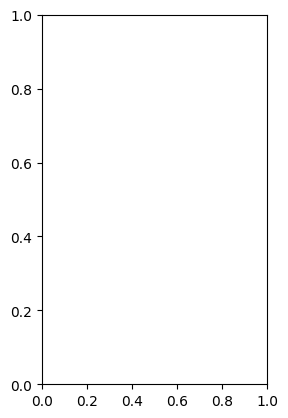

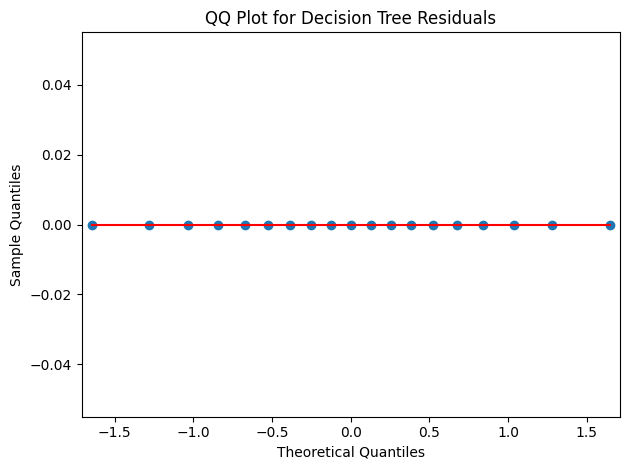

In [12]:
# QQ plots for residuals
plt.subplot(1, 2, 2)
sm.qqplot(tree_residuals, line='s')
plt.title('QQ Plot for Decision Tree Residuals')

plt.tight_layout()
plt.show()


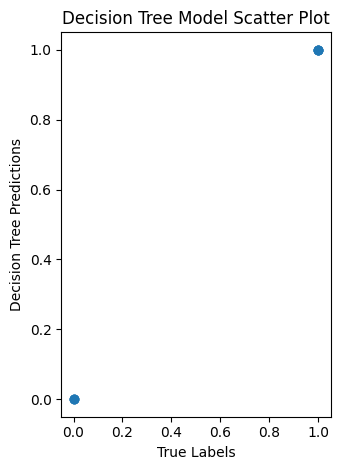

In [11]:
plt.subplot(1, 2, 2)
plt.scatter(test_labels, decision_tree_predictions, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Decision Tree Predictions')
plt.title('Decision Tree Model Scatter Plot')

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Regression Model Scatter Plot')

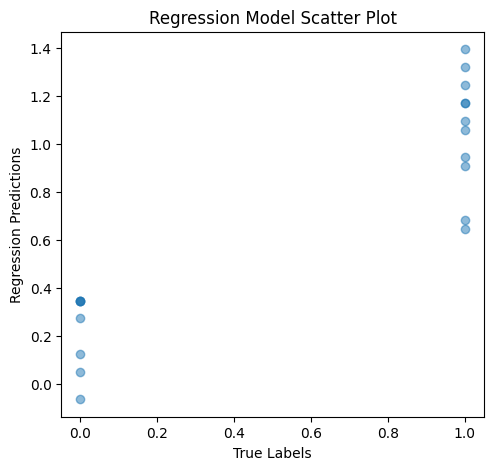

In [6]:
# Scatter Plots (for regression models)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(test_labels, regression_predictions, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Regression Predictions')
plt.title('Regression Model Scatter Plot')

In [7]:
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, auc):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()


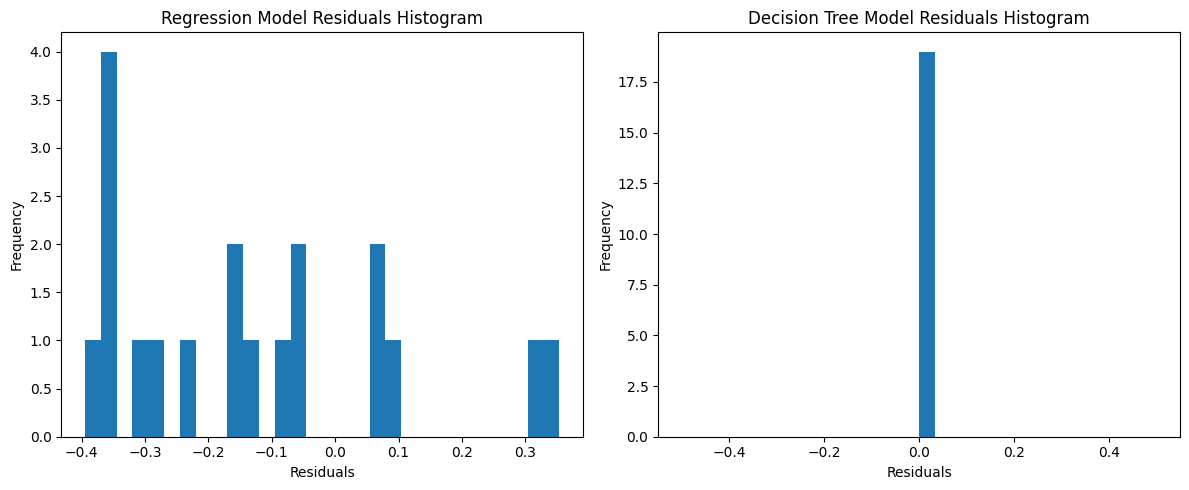

In [8]:
# Histograms (for regression models)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(test_labels - regression_predictions, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Regression Model Residuals Histogram')

plt.subplot(1, 2, 2)
plt.hist(test_labels - decision_tree_predictions, bins=30)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Decision Tree Model Residuals Histogram')

plt.tight_layout()
plt.show()

<ipython-input-9-a49ec94f3f29>:10: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


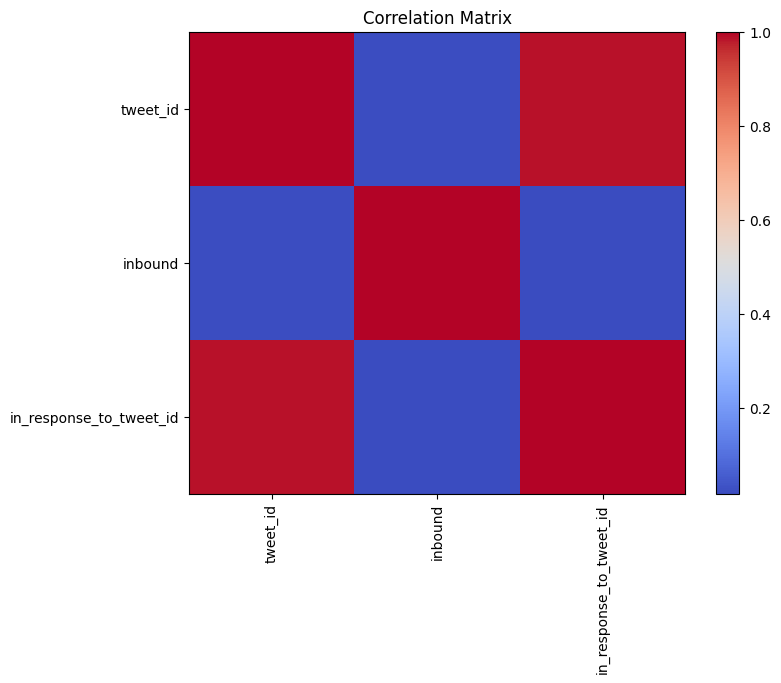

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data from a CSV file (replace 'your_data.csv' with your actual file path)
dataset_path = "/content/sample_data/sample.csv"
df = pd.read_csv(dataset_path)

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()


In [18]:
# Calculate the correlation between model predictions and true labels
correlation_dl = np.corrcoef(deep_learning_predictions.ravel(), test_labels.ravel())[0, 1]
correlation_regression = np.corrcoef(regression_predictions.ravel(), test_labels.ravel())[0, 1]
correlation_tree = np.corrcoef(decision_tree_predictions.ravel(), test_labels.ravel())[0, 1]

# Print correlation values
print("Correlation between Deep Learning Predictions and True Labels:", correlation_dl)
print("Correlation between Regression Predictions and True Labels:", correlation_regression)
print("Correlation between Decision Tree Predictions and True Labels:", correlation_tree)


Correlation between Deep Learning Predictions and True Labels: 0.9159095965610805
Correlation between Regression Predictions and True Labels: 0.8984369697650064
Correlation between Decision Tree Predictions and True Labels: 0.9999999999999998


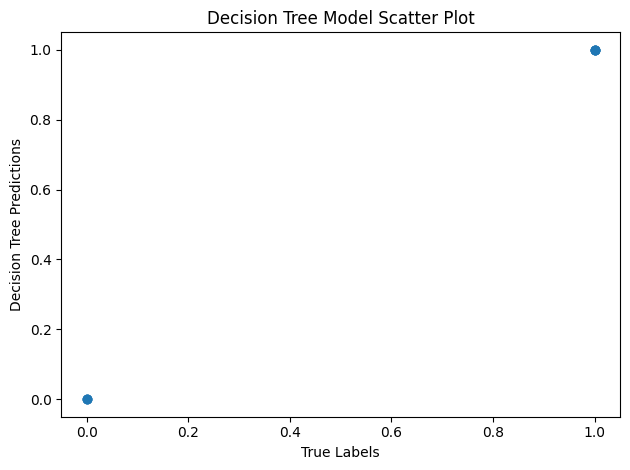

In [19]:
plt.scatter(test_labels, decision_tree_predictions, alpha=0.5)
plt.xlabel('True Labels')
plt.ylabel('Decision Tree Predictions')
plt.title('Decision Tree Model Scatter Plot')
plt.tight_layout()
plt.show()


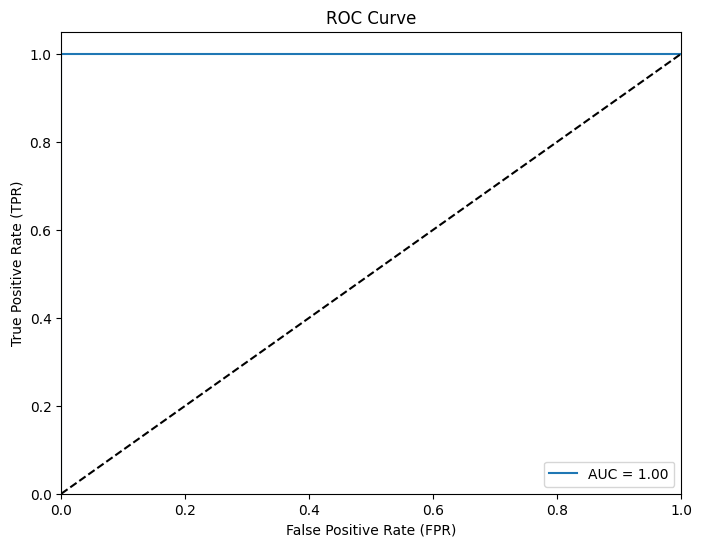

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

# ROC Curve for Deep Learning Model
fpr_dl, tpr_dl, _ = roc_curve(test_labels, deep_learning_predictions)
roc_auc_dl = roc_auc_score(test_labels, deep_learning_predictions)
plot_roc_curve(fpr_dl, tpr_dl, roc_auc_dl)
